The model was automatically reconstructed from sequenced genome (retrieved with NCBI RefSeq accession code) using carveme.
The anaerobic xylose medium with yeast-extract is defined in medium.tsv, which is used to gapfill and initialise exchange reaction bounds on the model.

To generate the model:

```
carve --refseq GCF_003014985.1 --gapfill nj4_med -i nj4_med --mediadb medium.tsv -o GEMs/NJ4.xml 
```

In [2]:
from cobra.io import read_sbml_model
from utils import model_validation as mv

nj4 = read_sbml_model('GEMs/NJ4.xml')

# Gapfilling

The model was gapfilled to grow on the specified medium. This was done during the construction process so that genomic evidence could be taken into account during the process.
Comparison of the non-gapfilled and the gapfilled models will follow.

In [3]:
nj4_original = read_sbml_model("GEMs/NJ4_nogapfill.xml")

print('before gapfilling there were', len(nj4_original.reactions), 'reactions')
print('after before gapfilling there were', len(nj4.reactions), 'reactions')
# get all reactions that are present in the gapfilled but not the original model
print('the added reactions are:')
print([r.id for r in nj4.reactions if r not in nj4_original.reactions])

before gapfilling there were 1647 reactions
after before gapfilling there were 1650 reactions
the added reactions are:
['BZDH', 'NDPK2', 'PHPYROX']


# Testing the model:

A sanity-check on the model and its capabilities should include:

1. check whether growth is possible on the medium,  
use ```growth_possible```.

1. check for energy-gerating cycles,  
use ```energy_generation_cycle```

1. check whether the exhange reactions exist in the model,  
use ```reactions_exist```.

2. check whether the exhange reactions are blocked,  
use ```check_blocked_reactions```.

2. check whether the exhange reactions can carry flux at optimal solution (FVA),  
use ```check_production```.

In [2]:
mv.growth_possible(nj4)

True

In [42]:
mv.energy_generation_cycle(nj4)

False

In [15]:
uptake_reactions = [
    'EX_xyl__D_e', # xylose exchange
]

production_reactions = [
    'EX_btoh_e', # butanol exhange
    'EX_etoh_e', # ethanol exchange
    'EX_ac_e', # acetate exchange
    'EX_but_e', # butyrate exchange
    'EX_acetone_e', # acetone exchange
]

In [4]:
mv.reactions_exist(nj4, uptake_reactions)

True

In [5]:
mv.reactions_exist(nj4, production_reactions)

The following reactions are missing: ['EX_btoh_e', 'EX_acetone_e']


False

In [6]:
existing_production_reactions = [
    'EX_etoh_e', # ethanol exchange
    'EX_ac_e', # acetate exchange
    'EX_but_e', # butyrate exchange
]

In [7]:
mv.check_blocked_reactions(nj4, existing_production_reactions)

['EX_ac_e', 'EX_but_e']

In [8]:
mv.check_production(nj4, existing_production_reactions)

,minimum,maximum
EX_etoh_e,15.445155,15.844752
EX_ac_e,0.000000,0.000000
EX_but_e,0.000000,0.000000


The out-of-the-box carveme model:
- can grow on the medium
- does not contain the exhange reactions for butanol or acetone
- does not contain acetone or butyrate production in its solution space (blocked reactions)
- needs to produce ethanol at optimal growth

## Troubleshooting the carveme generated model 

The metabolites and reactions in the ABE fermentation pathway has been identified (see personal notes) with BiGG identifiers.
Will begin by checking which are / are not present in the model:

In [9]:
metabolites = ['btoh', '1btol', 'btal', 'btcoa', 'butpi', 'but', 'acetone', 'acac', 'aacoa', 'b2coa', '3hbcoa', 'accoa', 'pyr']

for metabolite in metabolites:
    try:
        nj4.metabolites.get_by_id(str(metabolite+"_c"))
    except KeyError:
        print(metabolite, "not in model")

acetone not in model


In [16]:
for reaction in production_reactions:
    try:
        nj4.reactions.get_by_id(reaction)
    except KeyError:
        print(reaction, "not in model")

EX_btoh_e not in model
EX_acetone_e not in model


In [19]:
metabolite = "btoh"

try:
    nj4.metabolites.get_by_id(str(metabolite+"_e"))
except KeyError:
    print(str(metabolite+"_e"), "not in model")

btoh_e not in model


- all the (intracellular) metabolites required for the correct behaviour is present in the model appart from acetone. will focus on fixing this pathway first
- extracellular butanol and butanol exchange is missing, even though intracellular butanol is present. need to add butanol transport and exhange reactions

### identifying missing reactions

use the universal model to find *candidates* for reactions that connect 2 metabolites

In [16]:
from config import ROOT_DIR

universal_model = read_sbml_model(str(ROOT_DIR / "community_modelling" / "GEMs" / "bigg_universe.xml"))

No objective coefficients in model. Unclear what should be optimized


In [91]:
def find_reaction_connections(universal_model, A, B):
    """Find the reaction(s) that connect metabolite A and B in the universal model."""
    rx_A = universal_model.metabolites.get_by_id(A).reactions
    rx_B = universal_model.metabolites.get_by_id(B).reactions

    # get list of elements in both r1 and r2
    common = list(set(rx_A).intersection(rx_B))
    return [r.id for r in common]

In [13]:
find_reaction_connections(universal_model, "acetone_e", "acetone_c")

['ACEt', 'ACETONEt2']

In [12]:
find_reaction_connections(universal_model, "acac_c", "acetone_c")

['ADCi']

In [20]:
find_reaction_connections(universal_model, "btoh_e", "btoh_c")

['BTOHt']

In [17]:
# butabol transport reaction
BTOHt = universal_model.reactions.get_by_id('BTOHt')

# acetoacetate -> acetone + CO2
ADCi = universal_model.reactions.get_by_id("ADCi")

# acetone transport reaction
ACEt = universal_model.reactions.get_by_id("ACEt")

# acetoacetyl-CoA + butyrate -> acetoacetate + butanoyl-CoA
nj4.reactions.get_by_id("BUTCT2").bounds = (-1000, 1000) # make this reaction reversible like god intended

nj4.add_reactions([BTOHt, ADCi, ACEt])
nj4.add_boundary(nj4.metabolites.get_by_id('btoh_e'), type='exchange', reaction_id='EX_btoh_e', lb=0, ub=1000);
nj4.add_boundary(nj4.metabolites.get_by_id('acetone_e'), type='exchange', reaction_id='EX_acetone_e', lb=0, ub=1000);

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [18]:
mv.check_blocked_reactions(nj4, production_reactions)

['EX_ac_e', 'EX_but_e']

the production of acetate and butyrate is still blocked - use the cobrapy gapfill function to identify possible solutions:

In [90]:
from cobra.flux_analysis import gapfill

def find_gapfilling_reactions(model, universal_model, reaction):
    """Using cobrapy gapfill function, find reactions from the universal model that when added will unblock reaction."""
    
    with model:
        model.objective = model.reactions.get_by_id(reaction)
        gapfilling_reactions = gapfill(model, universal_model)
        
    return [r.id for r in gapfilling_reactions[0]]

In [34]:
find_gapfilling_reactions(nj4, universal_model, "EX_ac_e")

['ACt5pp']

In [36]:
find_gapfilling_reactions(nj4, universal_model, "EX_but_e")

['BUTt2rpp']


add in transport reactions between extracellular and cytosolic butyrate and acetate

In [19]:
# butyrate transport reaction
BUTt = universal_model.reactions.get_by_id('BUTt')

# acetate transport reaction
ACtr = universal_model.reactions.get_by_id("ACtr")

nj4.add_reactions([BUTt, ACtr])

In [20]:
assert mv.growth_possible(nj4)
assert not mv.energy_generation_cycle(nj4)
assert not mv.check_blocked_reactions(nj4, production_reactions)

Now no reactions are blocked - all tests are passed and the first stage of model testing and troubleshooting is completed. 
Script to run curation and save model as NJ4_curated is located in utils folder.

In [21]:
from cobra.io import write_sbml_model

write_sbml_model(nj4, "GEMs/NJ4_curated.xml")

## Further testing of model

next up: look into how the model behaves

In [1]:
from cobra.io import read_sbml_model
from utils import model_validation as mv

nj4 = read_sbml_model('GEMs/NJ4_curated.xml')

production_reactions = [
    'EX_btoh_e', # butanol exhange
    'EX_etoh_e', # ethanol exchange
    'EX_ac_e', # acetate exchange
    'EX_but_e', # butyrate exchange
    'EX_acetone_e', # acetone exchange
]

In [2]:
assert mv.growth_possible(nj4)
assert not mv.energy_generation_cycle(nj4)
assert not mv.check_blocked_reactions(nj4, production_reactions)

In [182]:
mv.check_production(nj4, production_reactions, fraction_of_optimum=1)

,minimum,maximum
EX_btoh_e,0.0,7.820022
EX_etoh_e,0.0,15.640044
EX_ac_e,0.0,11.210729
EX_but_e,0.0,11.210729
EX_acetone_e,0.0,0.000000


- it is expected that there cannot be consumption of any of these substances since there is none available in the medium

In [183]:
with nj4:
    nj4.reactions.EX_but_e.lower_bound = -10
    nj4.reactions.EX_ac_e.lower_bound = -10
    print(mv.check_production(nj4, production_reactions, fraction_of_optimum=1))

                minimum       maximum
EX_btoh_e      0.000000  1.282002e+01
EX_etoh_e      0.000000  2.564004e+01
EX_ac_e       -4.496405  2.121073e+01
EX_but_e     -10.000000  1.564004e+01
EX_acetone_e   0.000000  1.624048e-13


- if we add butyrate and acetate to the medium, they can be used as substrate (like they are during solventogenesis) and max possible butanol and acetone increases

In [23]:
genes = {'adhE1':'WP_010890846_1', 'adhE2':'WP_010890720_1', 'ctfA': 'WP_010890847_1', 'ctfB': 'WP_010890848_1'}

for gene, protein in genes.items():
    try:
        gpr = nj4.genes.get_by_id(protein)
        print(gene, ":", [r.id for r in gpr.reactions])
    except KeyError:
        print(gene, ": not in model")

adhE1 : not in model
adhE2 : ['BTS', 'BTCOARx', 'CHOLD3', 'BTS_nadph', 'ACALD', 'ALCD4', 'ALCD19', 'ALCD2x', 'IBHH', 'ALCD19y', 'BNOCA']
ctfA : ['BUTCT', 'ACACCT', 'HXCT', 'BUTCT2']
ctfB : ['BUTCT', 'ACACCT', 'BUTCT2']


Looking further into the enzyme complex ctfAB 3.8.3.8, it is important in transferring CoA groups between: 
- acetoacetyl-CoA / acetoacetate and acetyl-CoA / acetate (ACACCT)
- acetoacetyl-CoA / acetoacetate and butyryl-CoA / butyrate (BUTCT2)
- acetyl-CoA / acetate and butyryl-CoA / butyrate (BUTCT)

However, 'BUTCT', 'ACACCT' are one-way in the model, which means that the model will not be capable of uptaking acetate and butyrate to aid in acetone production (which is what happens in solventogenesis).
Remidying this by making the reactions reversible.

In [ ]:
nj4.reactions.get_by_id("BUTCT").bounds = (-1000, 1000) 
nj4.reactions.get_by_id("ACACCT").bounds = (-1000, 1000) 

shadow prices and reduced costs:

In [16]:
substrates = ["xyl__D_e", "but_e", "ac_e"]

with nj4:
    nj4.objective = "EX_btoh_e"
    sol = nj4.optimize()
    print(sol.shadow_prices[substrates])

xyl__D_e   -1.515152
but_e      -0.363636
ac_e        0.000000
Name: shadow_prices, dtype: float64


- when butanol is objective, the negative shadow price for butyrate suggests that butyrate presence would increase butanol production

In [17]:
sol = nj4.optimize()
sol_frame = sol.to_frame()
sol_frame[sol_frame["reduced_costs"] != 0].sort_values(by="reduced_costs")

,fluxes,reduced_costs
CPPPGO,0.0,-2.169306
H2SO,0.0,-2.085435
EX_bz_e,0.0,-1.103921
EX_o2_e,0.0,-1.042718
MMSAD1,0.0,-0.568961
...,...,...
ACt2ipp,0.0,0.020401
CLt3_2pp,0.0,0.020401
GTHRDt2,0.0,0.027201
MALt3r,0.0,0.040802


In [187]:
# saving model as json so it can be imported to escher to build map
from cobra.io import save_json_model
save_json_model(nj4, "GEMs/NJ4_map.json")

## Growth coupling

In [1]:
from cobra.io import read_sbml_model

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")

Initially, there was "negative growth-coupling" between acetate and butyrate production, meaning that as growth-rate was maximised, the FVA-max value for acetate and butyrate production approached zero.
This does not make sense, since acidogenesis is associated with growth in the exponential growth phase.  

Re-running the model reconstruction using soft constraints for butyrate and acetate was attempted, but this resulted in an identical model to the previously generated one.
A dive into the redox balance of the patwhays (detailed explenation in notes) revelaed that this might be due to a few missing reactions.
I added reactions for pyruvate -> acetyl-CoA formation via ferrodoxin (POR_syn), as well as NADH-mediuated ferrodoxin oxidation/reduction (FNRR), and NADH-mediated crotonyl-CoA -> butyryl-CoA (ACOAD1).
(There is evidence for all these reactions happening in *C. acetobutylicum* in the litterature - see notes)
Now there is no longer "negative growth-coupling"!

There is still no direct growth-coupling - but this is likely due to the fact that 0 butyrate and max acetate / 0 acetate and max butyrate both exist in the solution space. This was verified using a simple single-gene optknock implementation, which showed that knocking out gene(s) for butyrate production ensured growth-coupled acetate production, and visa-versa. (oops - this was done for the super-available medium not the smaller medium...)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

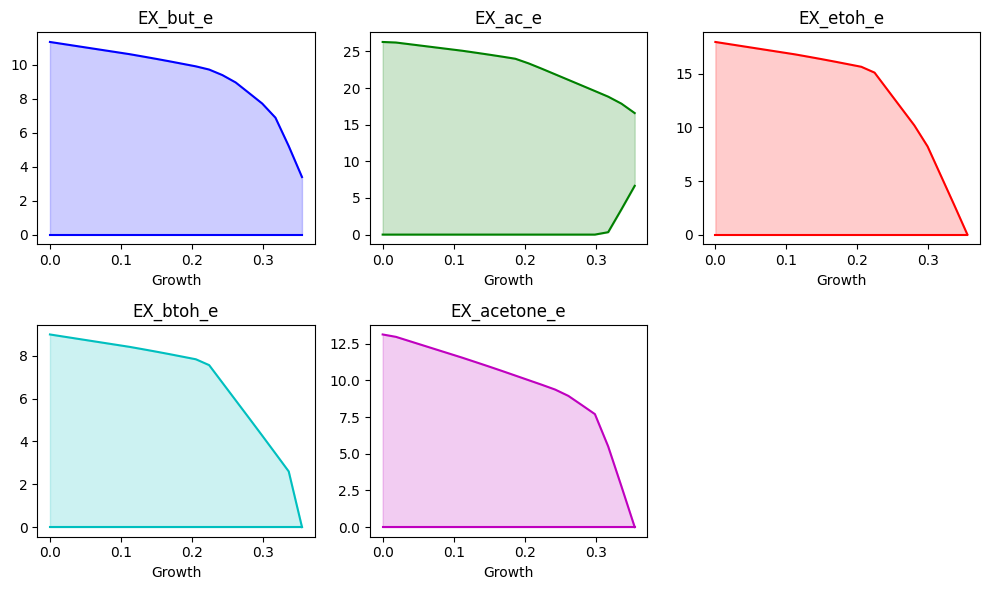

In [3]:
from utils import static_sim

medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_nh4_e": 10,}, fill_value=0.1)

prod_reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e", "EX_acetone_e"]

static_sim.plot_flux_envelopes(nj4, medium=medium, reactions=prod_reactions)

## Growth on other substrates?

In [2]:
from utils import static_sim

xylan_medium = static_sim.get_specific_medium(nj4, {"EX_xylan8_e": 1, "EX_xylan4_e": 1})

prod_reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e", "EX_acetone_e"]

with nj4:
    nj4.medium = xylan_medium
    sol = nj4.optimize()

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [4]:
import escher
from escher import Builder

builder_xylan = Builder(map_json='xylan_uptake_map.json', model=nj4, height=600)
builder_xylan.reaction_data = sol.fluxes

In [6]:
builder_xylan

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…

In [8]:
nj4.reactions.XYLANabc

Reaction identifier,XYLANabc
Name,Oligo-xylan ABC transport
Memory address,0x122ee8d90
Stoichiometry,"atp_c + h2o_c + xylan4_e --> adp_c + h_c + pi_c + xylan4_c ATP C10H12N5O13P3 + H2O H2O + Xylan (4 backbone units, 1 glcur side chain) --> ADP C10H12N5O10P2 + H+ + Phosphate + Xylan (4 backbone units, 1 glcur side chain)"
GPR,WP_010963503_1 and WP_010965671_1 and WP_010966457_1 and WP_010966903_1
Lower bound,0.0
Upper bound,1000.0


## More shadow-prices

In [169]:
from cobra.io import read_sbml_model
from utils import model_validation as mv

nj4 = read_sbml_model("GEMs/NJ4.xml")

In [188]:
with nj4:
    medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10})
    nj4.medium = medium
    sol = nj4.optimize()

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [189]:
sol_df = sol.shadow_prices.to_frame()

In [190]:
import pandas as pd

med = pd.read_csv("medium.tsv", sep="\t")
med_mets = [str(met + "_e") for met in med[med["medium"] == "nj4_med"]["compound"]]
other_mets = ["nadh_c", "nadph_c", "atp_c", "h_c", "nad_c", "nadp_c"]
interesting_mets = med_mets + other_mets

In [191]:
# filter df to get rows with interesting mets
sol_df[sol_df.index.isin(interesting_mets)].sort_values(by="shadow_prices", ascending=False)

,shadow_prices
mg2_e,-0.000000
his__L_e,-0.000000
k_e,-0.000000
mn2_e,-0.000000
mobd_e,0.000000
na1_e,-0.000000
ni2_e,0.000000
pheme_e,-0.000000
pi_e,-0.000000
pro__L_e,0.000000
